In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [2]:

df = pd.read_csv("creditcard.csv")
print("Data loaded. Shape:", df.shape)
df.head()


Data loaded. Shape: (1000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


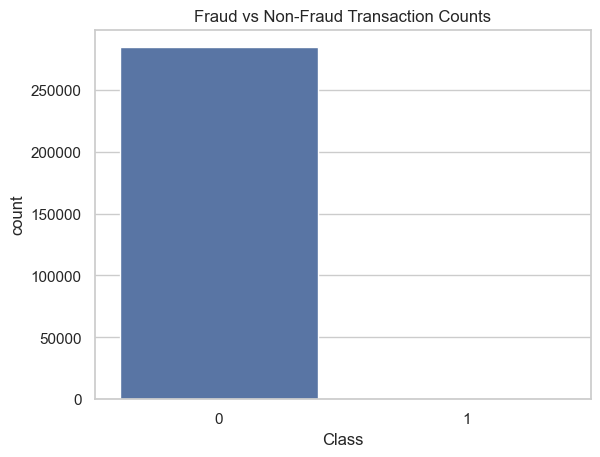

In [11]:

print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transaction Counts")
plt.show()


In [12]:

scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

df.drop(['Amount', 'Time'], axis=1, inplace=True)


In [13]:
X = df.drop('Class', axis=1)
y = df['Class']


In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (227845, 30)
Test shape: (56962, 30)


In [15]:

print("Before SMOTE:", y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [16]:

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_res, y_train_res)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# XGBoost
xgb = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [17]:

models = {"Logistic Regression": lr, "Random Forest": rf, "XGBoost": xgb}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]

    print(f"=== {name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("ROC AUC Score:", roc_auc_score(y_test, y_score))
    print("-" * 40)


=== Logistic Regression ===
Confusion Matrix:
 [[55406  1458]
 [    8    90]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC AUC Score: 0.9698482164390798
----------------------------------------
=== Random Forest ===
Confusion Matrix:
 [[56846    18]
 [   19    79]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9688195357630954
-------------------------------------

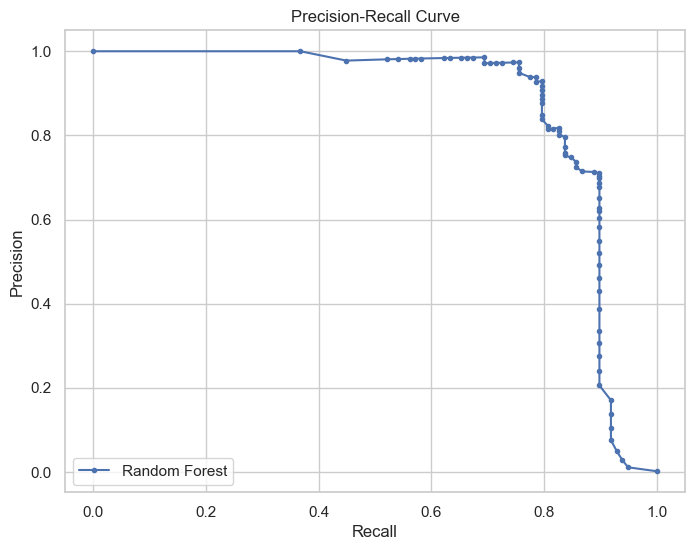

In [18]:
y_scores = rf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
